<IPython.core.display.Javascript object>


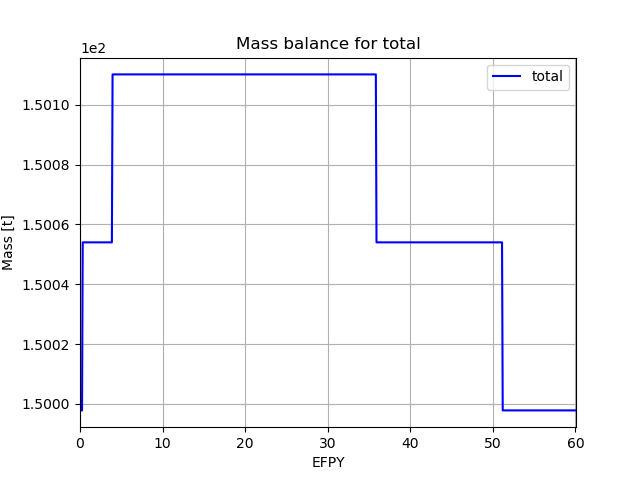

<IPython.core.display.Javascript object>


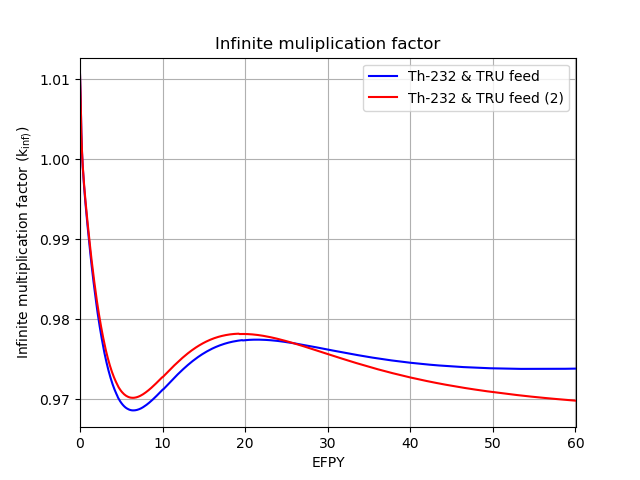


From SCALE
Breeding gain 0.0 kg/year
Mass change 0.0 %
(149.9977982348355, 149.9977982348355)

Total power generated over lifetime 64.02358322753905 GWe-y
Total thorium fed 43.682164353611036 t
Natural Thorium required per energy generated 0.6720999251903319 t/GWe-y, Bin ID: A

Fission Products reprocessed continuously over lifetime 52.10998437427301 t
Mass of SNF+HLW disposed per energy generated 0.8209443910433128 t/GWe-y, Bin ID: A
Mass of DU+RU+RTh disposed per energy generated: 0 Bin ID: A

Products from Rep/Sep technology RU: 4.234913, RTh: 17.720109, TRU: 6.292414, FP: 52.145587.
Cs, Ba, Rb, Sr reprocessing group, t: 0.035143

Correction in feeds
Total mass change 0.000000 t; rate of mass change 0.0000000000e+00 g/s
Old TRU feed rate 3.6613556106e-04 g/(s*MTU)
New TRU feed rate 3.6613556106e-04 g/(s*MTU)
New Th232 feed rate 7.0380696570e-04 g/(s*MTU)
(0.6519188, 'th232')
(2.5430498, 'u233')
(0.14893006, 'pu242')
(0.9323579, 'u234')
(0.26239774, 'pu238')
(0.49028882, 'cm244')
(0

In [58]:
%matplotlib notebook 
# Import modules
import numpy as np
import matplotlib.pyplot
#from pyne import serpent
from pyne import nucname
from scipy.stats.stats import pearsonr 
import itertools
##### Input parameters ####################
power = 2.4*0.444             # GW electric, thermal efficiency 44.4% assumed (MSBR)
MTIHM = 28.35190              # metric tons
th232_feed     = 8.131480189E-04 # g/(s*MTIHM) from SCALE input
iso = 'total'
waste_iso = 'total'
vol_fuel_se = 56.2e+6
waste_vol =  vol_fuel_se*(1488.235718/1982230.000000)     # in brackets volume ration from SCALE output
storage_vol =  vol_fuel_se*(1488.235718/1982230.000000)   # in brackets volume ration from SCALE output
waste_vol =  vol_fuel_se*(1488.235718/1982230.000000)     # in brackets volume ration from SCALE output

# SCALE output 
#filename_fuel  = '/home/andrei2/Desktop/ornl/rebus/scale/no_repr_depl/rebus_quarter_cell2.000000000000000000.plt'
filename_fuel  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mosart9/mosart_60yrs.000000000000000000.plt'
filename_waste  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mosart9/mosart_60yrs.000000000000000001.plt'
filename_storage= '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mosart7/mosart_60yrs.000000000000000002.plt'

k_file0         = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mosart5/mosart_60yrs.out'
k_file1         = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mosart8/mosart_60yrs.out'
k_file2         = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mosart9/mosart_60yrs.out'
#filename_blank = '/home/andrei2/Desktop/ornl/msfr/scale/no_reproc_depl/510efpd/anl425/quarter_cell2.000000000000000001.plt'
#print (dep0.keys())
#print (adens_fuel)
#print (n.index('Th232'))

def read_scale_out (filename):
    iso       = []
    adens     = []
    days_list = []
    with open(filename,'r') as infile:
        for line in itertools.islice(infile, 5, None):  # Skip file header start=6, stop=None
            p = line.split()
            iso.append(str(p[0]))
            adens.append(p[1:])  
            #iso.append(str(p[2]))
            #adens.append(str(p[3]))
    #u_en = 1e-6* np.flip (np.array (upp_enrg, dtype=float), 0 )               # Convert eV to MeV
    #flux = np.flip ( np.array (flux_list, dtype=float), 0 )
    #num_gr = len (u_en)
    days_list.append (iso[0])
    days_list = days_list + adens[0][:]
    adens_arr = np.asarray(adens[1:][:], dtype=np.float32)
    days = np.array (days_list, dtype=np.float32)
    return iso[1:], days/365, adens_arr/1e+6

def read_scale_k (filename):
    kinf = []
    with open(filename) as openfile:
        for line in openfile:
            if line.startswith('      Infinite neutron multiplication'):
                num = line.split(' ')[-1].strip()
                kinf.append(float(num))
    return kinf[1:]

def mass_of_elements (n_sc, mdens, vol, list_of_elements):
    mass = []
    for k in list_of_elements:
        for g in range(len(n_sc)-2):
            if nucname.znum(k) == nucname.znum(n_sc[g]):
                mass.append(mdens[g,-1]*vol )
    return sum (mass)                          # total mass, t

kinf0                                 = read_scale_k (k_file0)
kinf1                                 = read_scale_k (k_file1)
kinf2                                 = read_scale_k (k_file2)
n_sc, days_sc, mdens_fuel_sc          = read_scale_out (filename_fuel)
n_sc_st, days_sc, mdens_st            = read_scale_out (filename_storage)
n_sc_waste, days_sc, mdens_waste      = read_scale_out (filename_waste)
tot_mass_sc = mdens_fuel_sc[n_sc.index(iso),]*vol_fuel_se

# Heavy metal inventory
th_0  =  mdens_fuel_sc[n_sc.index('th232'),0]*vol_fuel_se
th_e  =  mdens_fuel_sc[n_sc.index('th232'),-1]*vol_fuel_se

# Online reprocessed materials
# U238 fed over lifetime
th_consumed = th232_feed * MTIHM * days_sc[-1] * 365 * 24 *3600 * 1e-6   # t th fed into the core
# FP removed continuously over lifetime
fp_removed    = mdens_waste[n_sc_waste.index('total')][-1]*waste_vol
# FP in fuel salt after 60 years of irradiation
gases_list    = ['kr','xe','ar','h','n','o']
noble_list    = ['se','nb','mo','tc','ru','rh','pd','ag','sb','te','zr','cd','in','sn']
rare_list     = ['y','la','ce','pr','nd','pm','sm','gd','eu','dy','ho','er','tb','ga','ge','as']
discard_list  = ['cs','ba','rb','sr']
fp_list = gases_list+noble_list+rare_list+discard_list
fp_left = mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, fp_list)
th_balance     =  th_0+th_consumed-th_e               # initial U + fed U - U left after 60yrs
##### Recovered materials from the fuel salt
recovered_mat_list = ['f','li','be','th','u','pu','np','am','cm']                  # list of useful materials we wanna recover after reactor shutdown
mass_recovered_mat = mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, recovered_mat_list)

##################### Fuel cycle metrics Generated (2.1.14) ###############
nat_u_per_energy = th_balance / (power*days_sc[-1])                        # Natural Uranium per energy generated
snf_hlw_per_energy= (fp_removed+mdens_fuel_sc[n_sc.index('total'),-1]*vol_fuel_se-mass_recovered_mat)/(power*days_sc[-1])  # SNF+HLW per energy generated
if nat_u_per_energy>=0 and nat_u_per_energy<3.8:
    metric_resource_utilization = 'A'
elif nat_u_per_energy>=3.8 and nat_u_per_energy<35.0:
    metric_resource_utilization = 'B'
elif nat_u_per_energy>=35.0 and nat_u_per_energy<145.0:
    metric_resource_utilization = 'C'
else: 
    metric_resource_utilization = 'D'

if snf_hlw_per_energy>=0 and snf_hlw_per_energy<1.65:
    metric_mass_of_snf_hlw = 'A'
elif snf_hlw_per_energy>=1.65 and snf_hlw_per_energy<3.0:
    metric_mass_of_snf_hlw = 'B'
elif snf_hlw_per_energy>=3.0 and snf_hlw_per_energy<6.0:
    metric_mass_of_snf_hlw = 'C'
elif snf_hlw_per_energy>=6.0 and snf_hlw_per_energy<=12.0:
    metric_mass_of_snf_hlw = 'D'
elif snf_hlw_per_energy>=12 and snf_hlw_per_energy<=36:
    metric_mass_of_snf_hlw = 'E'
else: 
    metric_mass_of_snf_hlw = 'F'
    
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#ax.set_ylim(0,0.00555)
#plot_title = 'Relative error in mass ' + str(100*abs(mdens_fuel_sc[n_sc.index(iso),-1]-mdens_fuel_se[n_se.index(iso.capitalize()),-1])/ 
#           mdens_fuel_se[n_se.index(iso.capitalize()),-1] ) + ' %\n'
#for i in [n_se.index(iso.capitalize())]:
#    ax.plot(days, mdens_fuel_se[i,:]*vol_fuel_se, '-',color='#ff8100', label=nucname.serpent(n_se[i])+'(Serpent)')
for k in [n_sc.index(iso)]:
    ax.plot(days_sc, mdens_fuel_sc[k]*vol_fuel_se, '-',color='blue', label=n_sc[k])
#for k in [n_sc_st.index(iso)]:
#    ax.plot(days_sc, mdens_st[k]*storage_vol, '-', color='red', label=n_sc_st[k]+' (storage)')
ax.legend(loc=0)
ax.set_ylabel('Mass [t]')
ax.set_xlabel('EFPY')
ax.set_title('Mass balance for ' + str (iso))
ax.set_xlim([0,np.amax(days_sc)])
#ax.set_xlim([0,2700])
fig_1.show()
#fig_1.savefig(str(iso)+'_mass.png',bbox_inches='tight', dpi=700)

# Initialize figure
fig_2 = matplotlib.pyplot.figure(2)
ax = fig_2.add_subplot(111)
ax.grid(True)
#ax.plot(days_sc, kinf0, '-',color='#ff8100', label='only Th-232 feed')
ax.plot(days_sc, kinf1, '-',color='blue', label='Th-232 & TRU feed')
ax.plot(days_sc, kinf2, '-',color='red', label='Th-232 & TRU feed (2)')
ax.legend(loc=0)
ax.set_ylabel('Infinite multiplication factor (k$_{\inf)}$)')
ax.set_xlabel('EFPY')
ax.set_title('Infinite muliplication factor')
ax.set_xlim([0,np.amax(days_sc)])
fig_2.show()
#fig_2.savefig('mosart_k_inf.png',bbox_inches='tight', dpi=700)


print ('\nFrom SCALE')
print ('Breeding gain ' + str (1e+3*365*(tot_mass_sc[-1] - tot_mass_sc[0])/days_sc[-1]) + ' kg/year' )
#print ('Breeding gain coefficient ' + str (365*(tot_mass_sc[-1] - tot_mass_sc[0])/(tot_mass_sc[0]*days_sc[-1])) )
#print ('\nDoubling time (net) ' + str( tot_mass_sc[0]/ (365*(tot_mass_sc[-1] - tot_mass_sc[0])/days_sc[-1] )) )

print ('Mass change '+ str( 100*(tot_mass_sc[-1] - tot_mass_sc[0]) /tot_mass_sc[0]) + ' %' )

print ( vol_fuel_se*mdens_fuel_sc[n_sc.index(iso),0], vol_fuel_se * mdens_fuel_sc[n_sc.index(iso),-1]   )
print ('\nTotal power generated over lifetime ' + str (power*days_sc[-1]) + ' GWe-y')
#print (u238_0, u238_e)
#print (u235_0, u235_e)
#print (u238_consumed)
print ('Total thorium fed ' + str ( th_consumed) + ' t'  )
# Assumptions:
# 1) Uranium from spent fuel salt after 60 years DID recovered (Table B61, Appendix B)
# 2) TRU material was taken from storage (nat U to produce TRU doesn't take into account)
print ('Natural Thorium required per energy generated ' + str ( nat_u_per_energy ) 
       + ' t/GWe-y, Bin ID: ' + str (metric_resource_utilization) )

print ('\nFission Products reprocessed continuously over lifetime ' + str (fp_removed) + ' t')
#print ('SNF overlifetime ' + str ( mdens_fuel_sc[n_sc.index('total'),-1]*vol_fuel_se ) + ' t' )
print ('Mass of SNF+HLW disposed per energy generated ' +
       str (snf_hlw_per_energy) +' t/GWe-y, Bin ID: '+str (metric_mass_of_snf_hlw))
print ('Mass of DU+RU+RTh disposed per energy generated: ' + str(0) + ' Bin ID: A' )

print ('\nProducts from Rep/Sep technology RU: %f, RTh: %f, TRU: %f, FP: %f.' 
       %(mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['u']),
         mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['th']),
         mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['pu','np','am','cm']),
         fp_removed+fp_left))
print ('Cs, Ba, Rb, Sr reprocessing group, t: %f' %mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['cs','ba','rb','sr']) )
print ('\nCorrection in feeds')
#print ('U removal %f t; rate of removal %.10e g/(s*MTU)'
#       %(mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['u']),
#         1e+6*mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['u'])/(365*24*3600*MTIHM*days_sc[-1])))
print ('Total mass change %f t; rate of mass change %.10e g/s' 
       %((mdens_fuel_sc[n_sc.index('total'),-1]-mdens_fuel_sc[n_sc.index('total'),0])*vol_fuel_se,
        ((mdens_fuel_sc[n_sc.index('total'),-1]-mdens_fuel_sc[n_sc.index('total'),0])*1e+6*vol_fuel_se)/
         (365*24*3600*days_sc[-1])))
print ('Old TRU feed rate %.10e g/(s*MTU)' %(3.6613556106e-04) )
print ('New TRU feed rate %.10e g/(s*MTU)' %(3.6613556106e-04-
    ((mdens_fuel_sc[n_sc.index('total'),-1]-mdens_fuel_sc[n_sc.index('total'),0])*1e+6*vol_fuel_se)/
         (365*24*3600*MTIHM*days_sc[-1]) ) ) 
print ('New Th232 feed rate %.10e g/(s*MTU)' %(7.038069657E-04-
    ((mdens_fuel_sc[n_sc.index('total'),-1]-mdens_fuel_sc[n_sc.index('total'),0])*1e+6*vol_fuel_se)/
         (365*24*3600*MTIHM*days_sc[-1]) ) ) 
balance_fuel = (mdens_fuel_sc[:-2,-1] - mdens_fuel_sc[:-2,0])*vol_fuel_se
for i in range (len(balance_fuel)):
    if balance_fuel[i] >= 0.1:
        print (balance_fuel[i], n_sc[i])